In [5]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
FILE_NAME = 'synthetic_gym_data.csv'

def load_and_preprocess_data(file_path):
    try:
        # Load the data.
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"FATAL ERROR: The file '{file_path}' was not found.")
        print("Please ensure you have run 'generate_data.py' successfully.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred during file reading: {e}")
        return None

    print("--- Starting Data Preprocessing ---")
    
    # Combine the separate Date and Time columns back into full datetime objects for analysis
    df['Check_In'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Check_In_Time'].astype(str))
    df['Check_Out'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Check_Out_Time'].astype(str))
    
    # Use datetime columns to calculate.
    df['WorkoutDuration'] = (df['Check_Out'] - df['Check_In']).dt.total_seconds() / 60
    
    df['DayOfWeek'] = df['Check_In'].dt.day_name()
    df['HourOfDay'] = df['Check_In'].dt.hour
    
    initial_rows = len(df)
    df = df[(df['WorkoutDuration'] >= 10) & (df['WorkoutDuration'] <= 240)].copy()
    print(f"Filtered {initial_rows - len(df)} outlier rows. Remaining rows: {len(df)}")
    
    print("--- Preprocessing Complete ---")
    print("\nCleaned DataFrame Head (showing new feature columns):")
    
    # Select key columns for display
    display_cols = ['User_ID', 'Date', 'Check_In_Time', 'Check_Out_Time', 'WorkoutDuration', 'DayOfWeek', 'HourOfDay', 'Workout_Type']
    print(df[display_cols].head())
    return df
df=load_and_preprocess_data(FILE_NAME)

--- Starting Data Preprocessing ---
Filtered 34 outlier rows. Remaining rows: 466
--- Preprocessing Complete ---

Cleaned DataFrame Head (showing new feature columns):
   User_ID        Date Check_In_Time Check_Out_Time  WorkoutDuration  \
0     1047  2025-09-01      05:22:00       05:54:00             32.0   
1     1006  2025-09-01      05:33:00       06:51:00             78.0   
2     1028  2025-09-01      07:08:00       08:00:00             52.0   
3     1035  2025-09-01      07:33:00       08:00:00             27.0   
4     1050  2025-09-01      07:45:00       08:00:00             15.0   

  DayOfWeek  HourOfDay Workout_Type  
0    Monday          5       Cardio  
1    Monday          5       Cardio  
2    Monday          7     Strength  
3    Monday          7     Strength  
4    Monday          7     Strength  


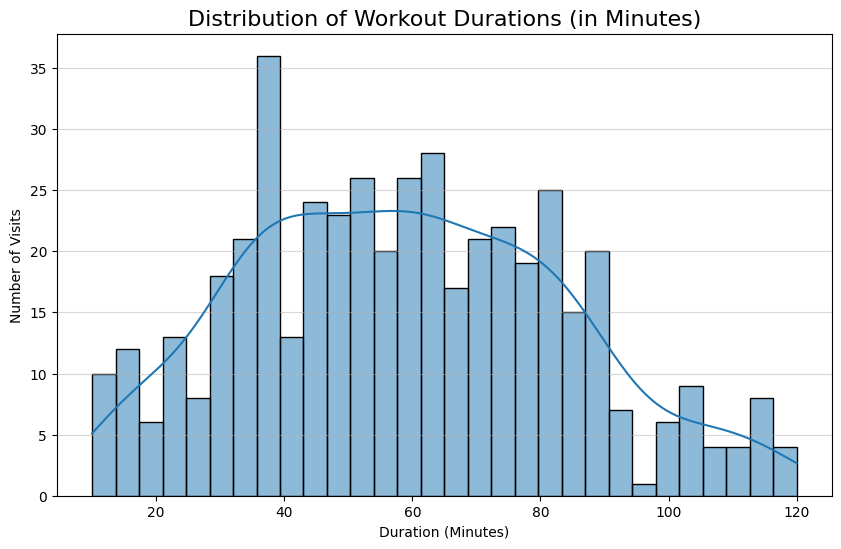

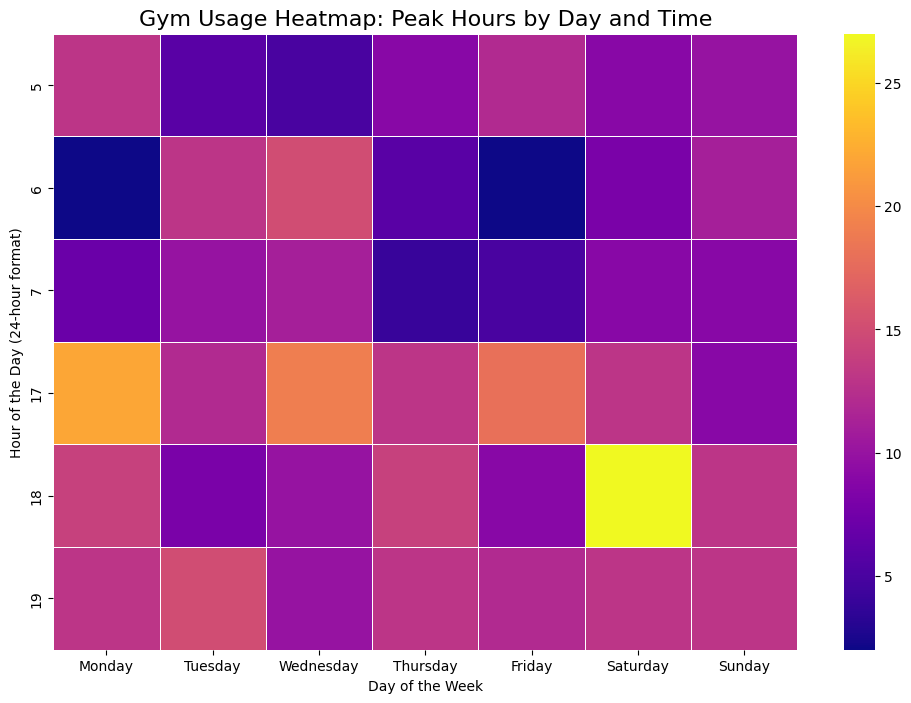

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['WorkoutDuration'], bins=30, kde=True)
plt.title('Distribution of Workout Durations (in Minutes)', fontsize=16)
plt.xlabel('Duration (Minutes)')
plt.ylabel('Number of Visits')
plt.grid(axis='y', alpha=0.5)
plt.savefig("distribution.png")
plt.show()
# This directly addresses the "heatmaps of gym usage by time/day" deliverable
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_data = df.groupby(['HourOfDay', 'DayOfWeek']).size().unstack().reindex(columns=day_order)

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="plasma", linewidths=.5)
plt.title('Gym Usage Heatmap: Peak Hours by Day and Time', fontsize=16)
plt.xlabel('Day of the Week')
plt.ylabel('Hour of the Day (24-hour format)')
plt.savefig("gym_usage_heatmap.png")
plt.show()

C:\Users\BIT\AppData\Local\Temp\ipykernel_13628\3052871471.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  footfall = df.set_index('Check_In').resample('H').size().reset_index(name='y')
02:45:07 - cmdstanpy - INFO - Chain [1] start processing
02:45:07 - cmdstanpy - INFO - Chain [1] done processing


Forecast Accuracy on last 6 hours (non-zero actuals):
MAE: 0.88 visitors
MAPE: 31.33%


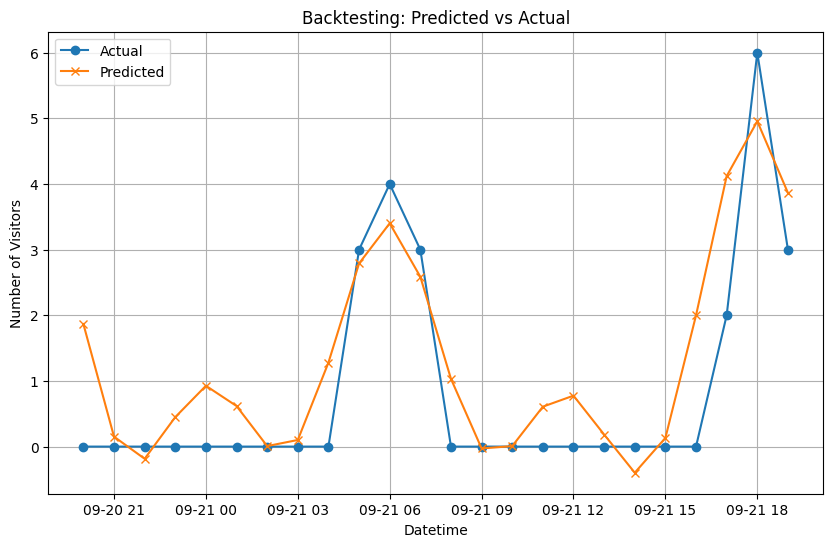

02:45:07 - cmdstanpy - INFO - Chain [1] start processing
02:45:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\BIT\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


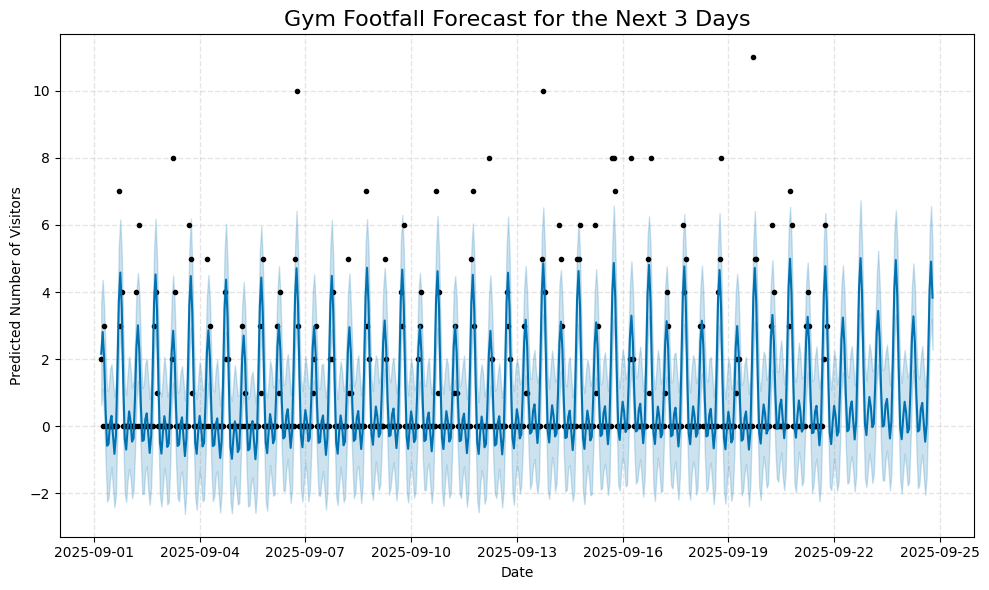

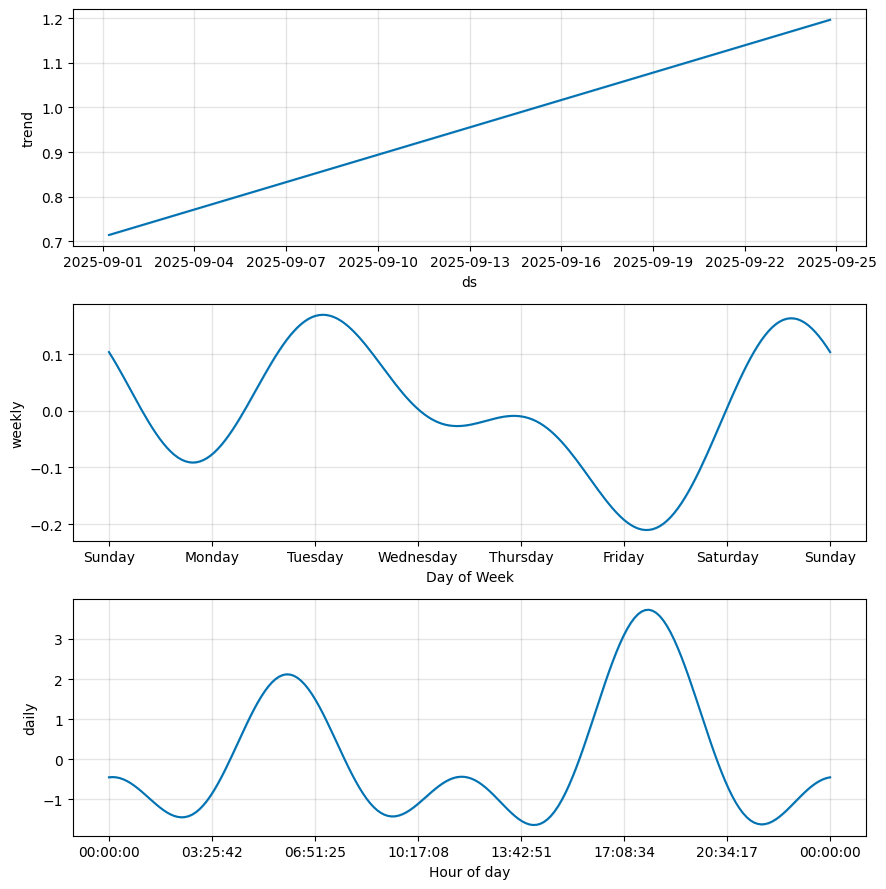

Interpretation: The components plot shows the daily and weekly patterns learned by Prophet.


In [11]:
def perform_forecasting(df):
    if df is None:
        return
    
    footfall = df.set_index('Check_In').resample('H').size().reset_index(name='y')
    footfall.rename(columns={'Check_In': 'ds'}, inplace=True)

    test_hours = 24
    train = footfall[:-test_hours]
    test = footfall[-test_hours:]

    model_error = Prophet(daily_seasonality=True, weekly_seasonality=True)
    model_error.fit(train)
    future_test = test[['ds']]
    forecast_test = model_error.predict(future_test)

    y_actual = test['y'].to_numpy()
    y_pred = forecast_test['yhat'].to_numpy()
    mask = y_actual != 0
    y_actual_nonzero = y_actual[mask]
    y_pred_nonzero = y_pred[mask]

    mae = np.mean(np.abs(y_actual_nonzero - y_pred_nonzero))
    mape = np.mean(np.abs((y_actual_nonzero - y_pred_nonzero) / y_actual_nonzero)) * 100

    print(f"Forecast Accuracy on last {len(y_actual_nonzero)} hours (non-zero actuals):")
    print(f"MAE: {mae:.2f} visitors")
    print(f"MAPE: {mape:.2f}%")

    plt.figure(figsize=(10,6))
    plt.plot(test['ds'], y_actual, label='Actual', marker='o')
    plt.plot(test['ds'], y_pred, label='Predicted', marker='x')
    plt.xlabel('Datetime')
    plt.ylabel('Number of Visitors')
    plt.title('Backtesting: Predicted vs Actual')
    plt.legend()
    plt.grid(True)
    plt.show()

    model = Prophet(daily_seasonality=True, weekly_seasonality=True)
    model.fit(footfall)
    future_dates = model.make_future_dataframe(periods=3*24, freq='H')
    forecast = model.predict(future_dates)

    fig = model.plot(forecast)
    plt.title('Gym Footfall Forecast for the Next 3 Days', fontsize=16)
    plt.xlabel('Date')
    plt.ylabel('Predicted Number of Visitors')
    plt.grid(True, which='both', linestyle='--')
    plt.tight_layout()
    plt.savefig("footfall.png")
    plt.show()

    fig_comp = model.plot_components(forecast)
    plt.savefig("userseg.png")
    plt.show()
    print("Interpretation: The components plot shows the daily and weekly patterns learned by Prophet.")
perform_forecasting(df)



User profiles for clustering:
   User_ID  total_visits  avg_duration
0     1001             9     73.444444
1     1002            19     59.210526
2     1003             8     53.000000
3     1004            12     46.833333
4     1005            10     58.500000
Clustering Quality (Silhouette Score): 0.46


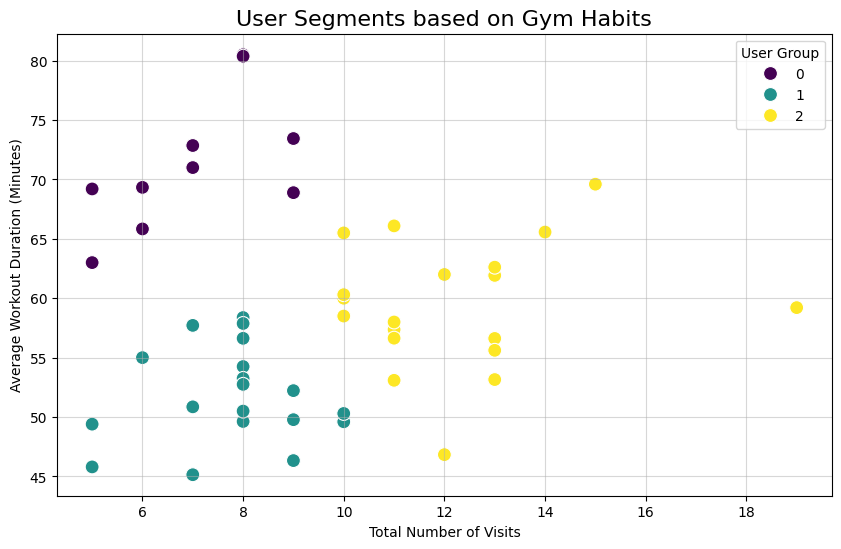

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Aggregate data to get metrics for each student
user_profiles = df.groupby('User_ID').agg(
    total_visits=('Check_In_Time', 'count'),
    avg_duration=('WorkoutDuration', 'mean')
).reset_index()

print("\nUser profiles for clustering:")
print(user_profiles.head())

# It's important to scale data before clustering
features = user_profiles[['total_visits', 'avg_duration']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Let's assume we want to find 3 user segments
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
user_profiles['cluster'] = kmeans.fit_predict(scaled_features)

# Calculate Silhouette Score
score = silhouette_score(scaled_features, user_profiles['cluster'])
print(f"Clustering Quality (Silhouette Score): {score:.2f}")

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=user_profiles,
    x='total_visits',
    y='avg_duration',
    hue='cluster',
    palette='viridis',
    s=100
)
plt.title('User Segments based on Gym Habits', fontsize=16)
plt.xlabel('Total Number of Visits')
plt.ylabel('Average Workout Duration (Minutes)')
plt.legend(title='User Group')
plt.grid(alpha=0.5)
plt.savefig("user.png")
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calculate_forecast_error(df):
    """
    Splits the data into a training and testing set, fits a Prophet model,
    and calculates the forecast error.
    """
    if df is None:
        return

    print("\\n--- Calculating Forecast Error ---")

    # 1. Aggregate data by the hour, just like in the original function
    footfall = df.set_index('Check_In').resample('h').size().reset_index(name='y')
    footfall.rename(columns={'Check_In': 'ds'}, inplace=True)

    # 2. Split data into training and testing sets
    # We'll use the last 7 days for our test set
    split_date = footfall['ds'].max() - pd.DateOffset(days=7)
    train_df = footfall[footfall['ds'] <= split_date]
    test_df = footfall[footfall['ds'] > split_date]

    print(f"Training data from {train_df['ds'].min()} to {train_df['ds'].max()}")
    print(f"Testing data from {test_df['ds'].min()} to {test_df['ds'].max()}\\n")

    # 3. Initialize and fit the Prophet model on the TRAINING data only
    model = Prophet(daily_seasonality=True, weekly_seasonality=True)
    model.fit(train_df)

    # 4. Predict the future values for the dates in our TEST set
    forecast = model.predict(test_df[['ds']])

    # 5. Merge actual values (y) from the test set with predicted values (yhat)
    results_df = pd.merge(test_df, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

    # 6. Calculate error metrics
    mae = mean_absolute_error(results_df['y'], results_df['yhat'])
    rmse = np.sqrt(mean_squared_error(results_df['y'], results_df['yhat']))

    print("--- Forecast Error Metrics ---")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}\\n")

    # 7. Plot the forecast against the actual test data
    plt.figure(figsize=(12, 6))
    plt.plot(results_df['ds'], results_df['y'], label='Actual Visits', color='black')
    plt.plot(results_df['ds'], results_df['yhat'], label='Predicted Visits', color='red', linestyle='--')
    plt.fill_between(results_df['ds'], results_df['yhat_lower'], results_df['yhat_upper'], color='red', alpha=0.2, label='Uncertainty Interval')
    plt.title('Forecast vs. Actuals for the Last 7 Days')
    plt.xlabel('Date')
    plt.ylabel('Number of Visitors')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the new function with your dataframe
calculate_forecast_error(df)